# PROYECTO INDIVIDUAL Nº1

## Machine Learning Operations (MLOps)

#### 0. Importamos librerías, definimos funciones y constantes

In [1]:
import pandas as pd
import json
import ast
import warnings
from io import StringIO
import hashlib
import matplotlib.pyplot as plt

from typing import List, Dict
import base64, csv

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px
import seaborn as sns
import importlib
from wordcloud import WordCloud


warnings.filterwarnings('ignore')

In [2]:

def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=columna.name)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()
  
def nulos_filas(data):
    # return pd.DataFrame(data.isna().sum(axis=1).value_counts().sort_values(ascending=False).reset_index().values, columns=['cant_col_nulas', 'cantidad'])
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().reset_index().values, columns=['cant_col_nulas', 'cantidad'])
  
def limpiar_funny(x: str)->int:
  temp = len(x)
  if temp == 0:
    return 0
  n = x.split(' ')[0]
  n = n.replace(',','')
  return int(n)

def limpiar_helpful(x: str)->float:
  if x == 'No ratings yet':
    return 1
  ns = x.split(' ')[:3]
  n1 = float(ns[0].replace(',',''))
  n2 = float(ns[2].replace(',',''))
  if ns[0] == 0:
    return -1.0
  return (n1/n2)

import string

def limpiar_posted(posted):
  posted = posted[7:-1].translate(str.maketrans('', '', string.punctuation))
  temp = posted.split()
  mes = temp[0]
  dia = temp[1]
  try:
    anio = temp[2]
  except:
    anio = '2016'

  return pd.to_datetime("-".join([dia, mes, anio]))

  import matplotlib.pyplot as plt

def showPie(columna, max=15):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

In [3]:
URL_STEAM_GAMES = 'datasets/origin/output_steam_games.json'
URL_USERS_ITEMS = 'datasets/origin/australian_users_items.json'
URL_USERS_REVIEWS = 'datasets/origin/australian_user_reviews.json'

# 1 Datasets Steams (ETL y EDA)

## 1.1 Dataset Steam Games

### 1.1.1 Leer archivo JSON

Ya que el archivo se encuentra en formato JSON, con llamar a la función built-in ```read_json()``` podemos crear un ```DataFrame``` para leer los valores.

In [4]:
df_games_all = pd.read_json(URL_STEAM_GAMES, lines=True)

### 1.1.2 Análisis de Valores Nulos

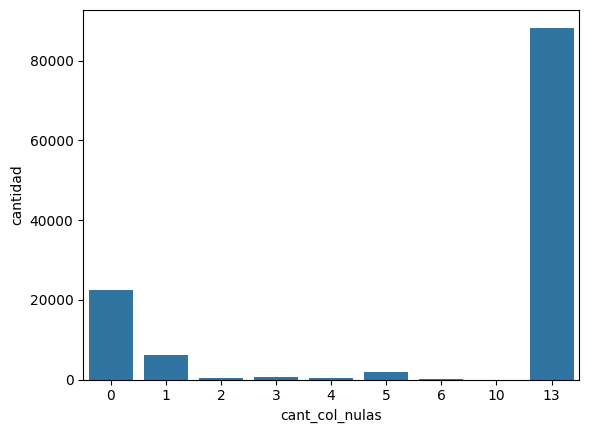

In [5]:
# Devuelve la cantidad filas que tienen la por cantidad de columnas nulas, es decir, 
# hay 88.310 filas que tienen 13 valores nulos, hay 22.530 filas que tienen 0 valores nulos

sns.barplot(x=nulos_filas(df_games_all).cant_col_nulas, y=nulos_filas(df_games_all).cantidad)
plt.show()

Revisando los valores nulos a lo largo del eje 1, vemos que hay un número muy grande (88310) de filas completamente vacías, ya que tiene 13 columnas el dataset y la cuenta de nulos es igual a ese valor. Por lo tanto, se recorta 
hasta n-1 valores nulos, es decir, como mínimo tiene que tener una columna no nula.

In [6]:
# Cantidad de Columnas
N = len(df_games_all.columns)

# Recorte de filas con valores nulos
df_games = df_games_all.drop( df_games_all[df_games_all.isna().sum(axis=1) > (N - 1) ].index)

### 1.1.3 Verificar duplicados

In [7]:
# Utilizamos una funcion de hash para verificar los duplicados por fila

# Es necesario convertrir a ```str``` los objetos
df_str = df_games.astype(str).duplicated()

print(f'Cantidad de filas duplicadas: {df_str.sum()}')


Cantidad de filas duplicadas: 0


### 1.1.4 Analizar todas las columnas para quitar redundancias e información no útil para el análisis

In [8]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 88310 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 3.2+ MB


Vistazo de valores Nulos

In [9]:
pd.DataFrame(df_games.isna().sum()).T

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,8052,3283,2,2050,0,2067,163,2,670,1377,0,2,3299


Las columnas ```title``` y ```app_name``` parecen contener lo mismo, comparamos

In [10]:
cantidad_filas = 0
cantidad_coincidencias = 0

for i in df_games.index:
    cantidad_filas += 1
    if (df_games.loc[i]['app_name'] == df_games.loc[i]['title']) and (not pd.isna(df_games.loc[i]['title'])):
        cantidad_coincidencias += 1

print(f'Porcentaje de Coincidencias: {(cantidad_coincidencias / cantidad_filas)*100:.2f} %')

Porcentaje de Coincidencias: 91.89 %


In [11]:
# Conteo de valores Nulos para cada columnas

pd.DataFrame(df_games[['title','app_name']].isna().sum().T, columns=['Cantidad de Nulos'])


,Cantidad de Nulos
title,2050
app_name,2


Teniendo en cuenta que la alta similitud de ambas columnas y que la columna ```app_name``` posee significativamente menos valores nulos, asumimos que dicha columna aporta más información, razón que nos permite prescindir de ```title```.

Preview de columnas deseadas

In [12]:
df_games.url.head(3), df_games.reviews_url.head(3), df_games.specs.head(3), df_games.publisher.head(3), df_games.developer.head(3)

(88310    http://store.steampowered.com/app/761140/Lost_...
 88311    http://store.steampowered.com/app/643980/Ironb...
 88312    http://store.steampowered.com/app/670290/Real_...
 Name: url, dtype: object,
 88310    http://steamcommunity.com/app/761140/reviews/?...
 88311    http://steamcommunity.com/app/643980/reviews/?...
 88312    http://steamcommunity.com/app/670290/reviews/?...
 Name: reviews_url, dtype: object,
 88310                                      [Single-player]
 88311    [Single-player, Multi-player, Online Multi-Pla...
 88312    [Single-player, Multi-player, Online Multi-Pla...
 Name: specs, dtype: object,
 88310           Kotoshiro
 88311    Making Fun, Inc.
 88312        Poolians.com
 Name: publisher, dtype: object,
 88310           Kotoshiro
 88311    Secret Level SRL
 88312        Poolians.com
 Name: developer, dtype: object)

Las columnas ```url```, ```reviewes_url```, ```specs``` contienen información considerada superflua para el análisis, ```publisher``` duplica información, al igual que ```early_access```.

In [13]:
columnas_a_quitar = ['title','url','reviews_url', 'early_access', 'publisher', 'specs']

In [14]:
df_games.drop(columnas_a_quitar, axis=1, inplace=True)

Reorganizamos las columnas a comodidad

In [15]:
df_games = df_games[['id','app_name', 'genres', 'release_date', 'tags', 'price', 'developer']]

In [16]:
df_games.head(3)

,id,app_name,genres,release_date,tags,price,developer
88310,761140.0,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro
88311,643980.0,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,Secret Level SRL
88312,670290.0,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,Poolians.com


Seguimos trabajando con las columnas

#### 1.1.4.1. ```App_Name```

In [17]:
# Buscamos nulos
df_games[df_games.app_name.isna()]

,id,app_name,genres,release_date,tags,price,developer
88384,NaN,None,None,None,None,19.99,None
90890,317160.0,None,"[Action, Indie]",2014-08-26,"[Action, Indie]",None,None


In [18]:
try:
    df_games.drop(88384, inplace=True)
except:
    print('No encontrado')

Buscando en la información duplicada que no usaremos para el análisis, pero la tenemos disponibles, conseguimos el valor en la columna ```title```, ya descartada, pero nos ayudó a obtener la info de estos nulos.

In [19]:
df_games.loc[90890, 'app_name'] = 'Duet'
df_games.loc[90890]

id                     317160.0
app_name                   Duet
genres          [Action, Indie]
release_date         2014-08-26
tags            [Action, Indie]
price                      None
developer                  None
Name: 90890, dtype: object

#### 1.1.4.2 ```Id```

In [20]:
df_games[df_games.id.isna()]

,id,app_name,genres,release_date,tags,price,developer
119271,NaN,Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]",2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",19.99,"Rocksteady Studios,Feral Interactive (Mac)"


Al igual que hicimos anteriormente encontramos el valor en columnas que duplican información, en este caso ```URL```.

In [21]:
df_games.loc[119271,'id'] = 200260

Ahora consideramos que es apto resetear el índice

In [22]:
df_games.reset_index(inplace=True)
df_games.drop('index', axis=1, inplace=True)

Buscamos items duplicados de la columna id y eliminarlos, con el objetivo de usar la columna como identificador.

In [23]:
cuenta_duplicados = df_games.id.value_counts()
id_dups = cuenta_duplicados[cuenta_duplicados.values > 1].keys()

Obtenemos el id del máximo valor y lo eliminamos

In [24]:
to_b = []

for i in id_dups:
  to_b.append(df_games[df_games['id'] == i].id.idxmax())

df_games.drop(to_b, axis=0, inplace=True)

In [25]:
df_games = df_games.set_index(df_games['id'].astype(int))
df_games.id = df_games.id.astype(int)
df_games.rename_axis('index', inplace=True)
df_games.rename(columns={'id': 'id_game'}, inplace=True)

In [26]:
df_games.head(2)

,id_game,app_name,genres,release_date,tags,price,developer
index,,,,,,,
761140,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro
643980,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,Secret Level SRL


#### 1.2.4.3 ``` Price ```

In [27]:
def isnumber(x):
    try:
        x = float(x)
        return x
    except:
        return 0

In [28]:
### Transformamos los valores a número, ```Free to Play = 0 ```

df_games.price = df_games.price.apply(isnumber)

#### 1.2.4.4 ```release_date``` y ```release_year```

In [29]:
to_date = lambda x: pd.to_datetime(x, errors='coerce')

fechas = df_games['release_date'].apply(to_date)
df_games['release_year'] = df_games['release_date'].apply(to_date)
df_games['release_year'] = df_games['release_date'].apply(to_date)
df_games['release_year'] = df_games['release_year'].dt.year.fillna(1900).astype(int)

#### 1.2.4.5 ``` genres ``` y ``` tags ```

In [30]:
juego_genero = df_games['genres'].explode()

In [31]:
df_games['genres_tags'] = df_games['genres'] + df_games['tags']
df_games['genres_tags']	= df_games['genres_tags'].apply(lambda x: pd.Series(x).drop_duplicates().tolist())
df_games['genres_tags'].explode().fillna('Generic', inplace=True)
words = df_games['genres_tags'].explode().explode().dropna().values

EDA

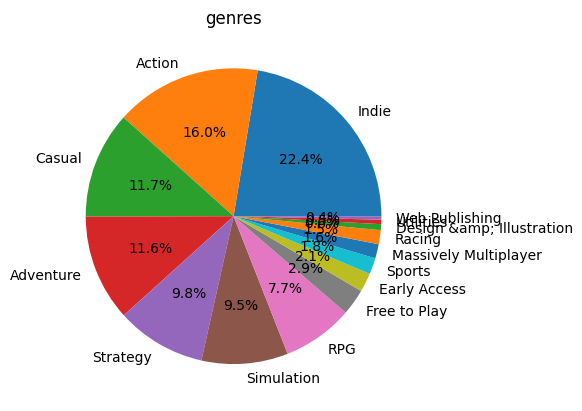

In [32]:
showPie(juego_genero)

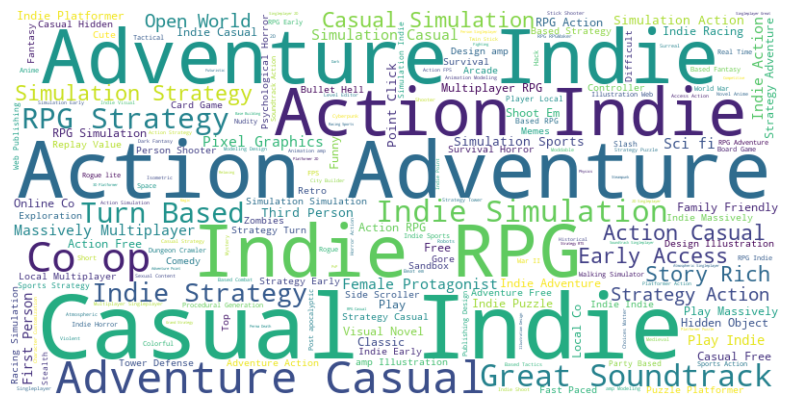

In [33]:

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Sistema de Recomendación

Ahora con la información disponible, trabajamos para hacer la matriz necesaria para el Endpoint de Machine Learning

In [175]:
# Obtenemos un arreglo con todos los géneros y etiquetas por juego 
generos_tags = [[row['id_game'], *row['genres_tags']] for _, row in df_games.iterrows()]

# Obtenemos un arreglo de tuplas con el par, juego- genero/etiqueta
tuplas = [[i[0], j] for i in generos_tags for j in i[1:]]


In [177]:
# Creamos un dataset con las tuplas
df_juego_genero_tag = pd.DataFrame(tuplas, columns=['id_game', 'genero_tag'])

# Eliminamos duplicados
df_juego_genero_tag = df_juego_genero_tag.dropna().drop_duplicates().reset_index()


In [178]:
# Elegimos el nro de generos para el dataset de análisis, ya que la cantidad es muy grande, elegimos los más representativos
nro_generos_tag = 30

In [179]:
# Recortamos el Dataset
recorte = df_juego_genero_tag['genero_tag'].value_counts().reset_index().head(nro_generos_tag)

df_juego_genero_tag_recortado = df_juego_genero_tag[df_juego_genero_tag.genero_tag.isin(recorte['genero_tag'])]
df_juego_genero_tag_recortado = df_juego_genero_tag_recortado.dropna().drop_duplicates().drop('index', axis=1).reset_index(drop=True)

In [181]:
# Ahora usando la función get_dummies, logramos generar una matriz deseada para el análisis
matriz_dummies = pd.get_dummies(df_juego_genero_tag_recortado, dtype=int, prefix='gen')

# Agrupamos cada juego por una fila y sumamos los valores
matriz_dummies = matriz_dummies.groupby('id_game').sum()

In [39]:
# Es el filtro para recortar el set de juegos, de un tamaño mayor a 30000
filter_games_df = None

# Usamos los items solo vistos en la reviews? No
items_reviews_filter = False

if items_reviews_filter:
    items_unicos = pd.read_csv('datasets/id_items_unicos.csv')
    items_unicos.columns = ['index', 'id_game']
    filter_games_df = items_unicos

In [182]:
# Usamos como filtro los juegos que salen en el dataset de estadìsticas? Sí
stats_filter = True

if stats_filter:
    stats = pd.read_csv('datasets/df_games_stats_user.csv')
    stats  = stats.rename({'item_id': 'id_game'}, axis=1)
    filter_games_df = stats

In [183]:
# Actualizamos el filtro por las horas jugadas, al menos 24 hs
filter_games_df = filter_games_df.groupby('id_game').sum('playtime_forever').query('playtime_forever > 1440')

In [42]:
# Creamos la matriz filtrada para el sistema de recomendación
if filter_games_df is not None and not filter_games_df.empty:
    matriz_dummies_filtrada = pd.merge(matriz_dummies, filter_games_df, left_on='id_game', right_on='id_game')

matriz_dummies_filtrada.head(3)

,gen_2D,gen_Action,gen_Adventure,gen_Anime,gen_Atmospheric,gen_Casual,gen_Co-op,gen_Difficult,gen_Early Access,gen_Fantasy,...,gen_Sci-fi,gen_Shooter,gen_Simulation,gen_Singleplayer,gen_Sports,gen_Story Rich,gen_Strategy,playtime_forever,playtime_2weeks,total_play
id_game,,,,,,,,,,,,,,,,,,,,,
10,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,2106016,21209,2127225
20,0,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,1,0,168263,13071,181334
30,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,158986,13019,172005


In [45]:
# Generamos dataset para las funciones Endpoint

stats = stats.rename({'item_id': 'id_game'}, axis=1)
df_ex = df_games.genres.explode().rename_axis('id_game').reset_index()
stats = pd.read_csv('datasets/df_games_stats_user.csv').rename({'item_id': 'id_game'}, axis=1)
all_genres = df_games['genres'].explode().rename_axis('id_game')
all_years = df_games[ 'release_year'].explode().rename_axis('id_game')
genre_year = pd.merge(all_genres, all_years, left_on='id_game', right_on='id_game')
year_user_genre = pd.merge(stats, genre_year, left_on='id_game', right_on='id_game').groupby(['release_year','user_id', 'genres']).sum(['playtime_forever'])
matriz_generos = pd.merge(pd.DataFrame(all_genres), filter_games_df, left_on='id_game', right_on='id_game')
df_games_join = df_games[['genres', 'release_year', 'id_game']]

genero_estadisticas = pd.merge(matriz_generos, df_games_join, left_on='id_game', right_on='id_game').groupby(['genres_x', 'release_year']).sum('playtime_forever')
genero_estadisticas.to_csv('datasets/generos_estadisticas.csv')

genero_estadisticas = pd.read_csv('datasets/generos_estadisticas.csv')
genero_estadisticas = genero_estadisticas.set_index(['genres_x', 'release_year'])

In [61]:
# Limpiamos la matriz de data learning

to_drop = matriz_dummies_filtrada.sum()[matriz_dummies_filtrada.sum() == 0].index.to_list()

matriz_dummies_filtrada.drop(to_drop, axis=1, inplace=True)
matriz_dummies_filtrada = matriz_dummies_filtrada.drop(['playtime_forever','playtime_2weeks',	'total_play'], axis=1)

# Guardamos la matriz
matriz_dummies_filtrada.to_csv('datasets/matriz_dummies_filtrada.csv')

In [186]:
from sklearn.metrics.pairwise import cosine_similarity

# Comparar 2 filas y obtener la similitud del coseno
def comparar(id_1, id_2):
    row1 = matriz_dummies_filtrada.loc[id_1].values.reshape(1,-1)
    row2 = matriz_dummies_filtrada.loc[id_2].values.reshape(1,-1)
    return cosine_similarity(row1, row2)    

# Esbozo de una funcion que compara el juego elegido con los demás
def get_recommended(id_juego):
    lista = []
    # id_juego = matriz_dummies.sample().index

    for i in matriz_dummies_filtrada.index.tolist():
        if i != id_juego:
            (a, b) = i, comparar(id_juego, i)
            if 0.5 < b[0][0] <= 1:
                lista.append((a, b[0][0]))
    
    return pd.DataFrame(lista, columns=['id_juego', 'similitud']).sort_values('similitud', ascending=False).head(5)


In [187]:
id_juego = 400

# Prueba
get_recommended(id_juego)

,id_juego,similitud
392,228300,0.904534
109,17410,0.904534
9,620,0.870388
472,245280,0.858116
97,15130,0.858116


## 1.2 User Items

#### 1.2.1 ETL

In [69]:
lines_items = []
json_lines_items = []

with open(URL_USERS_ITEMS, 'r', encoding='utf-8') as f_items:
    for line in f_items:
        lines_items.append(line)

In [70]:
json_lines_items = []

In [71]:
json_lines_items = []

for i, linea in enumerate(lines_items):
  try:
    json_lines_items.append(json.dumps(ast.literal_eval(linea)))
  except:
    pass


In [72]:
dfs = []

# Read JSON lines in chunks of 5000 lines each
chunksize = 5000
for chunk in range(0, len(json_lines_items), chunksize):
    chunk_data = "\n".join(json_lines_items[chunk:chunk + chunksize])
    df_chunk = pd.read_json(chunk_data, lines=True)
    dfs.append(df_chunk)

# Concatenate the DataFrames into a single DataFrame
df_users_stats = pd.concat(dfs, ignore_index=True)

In [73]:
lista = []

for i in range(df_users_stats.shape[0]):
  id_usuario = df_users_stats.iloc[i,0]
  dic = df_users_stats.iloc[i,4]
  for j, it in enumerate(dic):
    item_id = dic[j]['item_id']
    item_name = dic[j]['item_name']
    item_play_time = dic[j]['playtime_forever']
    item_pt2 = dic[j]['playtime_2weeks']
    tupla = (id_usuario, item_id, item_name, item_play_time, item_pt2)
    lista.append(tupla)

In [74]:
columnas = ['user_id','item_id', 'item_name', 'playtime_forever', 'playtime_2weeks']

In [75]:
df_usuarios_est = pd.DataFrame(lista, columns=columnas)

In [76]:
df_usuarios_est = df_usuarios_est[['user_id', 'item_id', 'playtime_forever']].query("playtime_forever > 1440")

In [77]:
df_usuarios_est.groupby(['user_id', 'item_id']).sum().to_csv('datasets/df_games_stats_user_item.csv')

In [78]:
df_usuarios_est.item_id = df_usuarios_est.item_id.astype(int)

<Axes: xlabel='playtime_forever', ylabel='Count'>

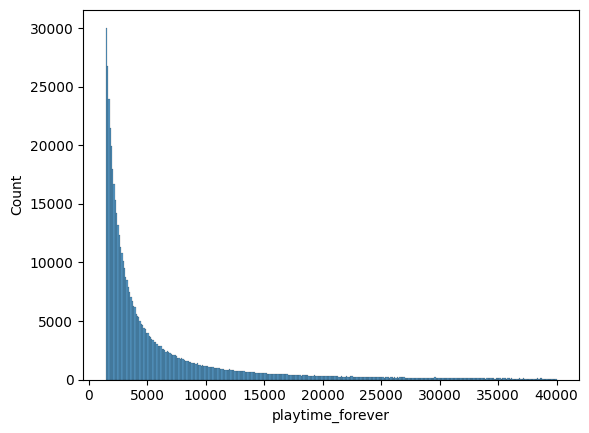

In [79]:
sns.histplot(df_usuarios_est.query("playtime_forever < 40000").playtime_forever)
plt.show()

#### 1.2.2 Creamos Datasets y recortamos la info para los siguientes pasos en la API

In [80]:
df = df_usuarios_est.groupby('user_id').sum().sort_values(by='playtime_forever', ascending=False)


In [81]:
mas_jugadores = df.head(1000).index

In [83]:
df = df_usuarios_est[df_usuarios_est.sort_values(by='playtime_forever', ascending=False).user_id.isin(mas_jugadores.values)].sort_values(by='playtime_forever', ascending = False)
# df

In [84]:
df = df_usuarios_est[df_usuarios_est.sort_values(by='playtime_forever', ascending=False).user_id.isin(mas_jugadores.values)].sort_values(by='playtime_forever', ascending = False)
df.rename({'item_id': 'id_game'}, axis=1, inplace=True)

pd.merge(all_genres, df, left_on='id_game', right_on='id_game').groupby(['user_id', 'genres']).sum().sort_values('playtime_forever', ascending=False).drop(['id_game'], axis=1).to_csv('user_genre_playtime.csv')

In [85]:
mas_jugadores = pd.merge(all_genres, df, left_on='id_game', right_on='id_game').groupby(['user_id']).sum().sort_values('playtime_forever', ascending=False).drop(['id_game'], axis=1)
# mas_jugadores

In [86]:
usuario_genero = pd.merge(all_genres, df, left_on='id_game', right_on='id_game').groupby(['user_id', 'genres']).sum().sort_values('playtime_forever', ascending=False).drop(['id_game'], axis=1)
usuario_genero.to_csv('datasets/usuario_genero.csv')


In [87]:
merged_1 = pd.merge(all_genres, df, left_on='id_game', right_on='id_game')
merged_2 = pd.merge(merged_1, df_games[['id_game','release_year']], left_on='id_game', right_on='id_game').groupby(['user_id', 'genres', 'release_year']).sum().sort_values('playtime_forever', ascending=False).drop(['id_game'], axis=1)

merged_2
merged_2.to_csv('datasets/merged_2.csv')


## 1.3 Reviews

#### 1.3.1 ETL

In [190]:
URL_USERS_REVIEWS

'datasets/origin/australian_user_reviews.json'

In [89]:
lines_r = []

with open(URL_USERS_REVIEWS, 'rt', encoding= 'utf-8') as rev_file:
  for i, line in enumerate(rev_file):
    lines_r.append(ast.literal_eval(line))


In [90]:
df_revs = pd.DataFrame(lines_r)

In [91]:
columnas: List[str] = ['id_usuario', 'funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend', 'review']

In [92]:
columnas = ['id_usuario']
columnas.extend(df_revs.reviews[0][0].keys())

In [93]:
lista_revs = []

for i in df_revs.index:
  id_usuario = df_revs.loc[i, 'user_id']
  dic = df_revs.loc[i, 'reviews']
  for it in dic:
    tupla = [id_usuario,*it.values()]
    lista_revs.append(tupla)

In [94]:
df_revs = pd.DataFrame(lista_revs, columns=columnas)

In [95]:
pd.Series(df_revs.item_id.unique()).to_csv('datasets/id_items_unicos.csv')

In [96]:
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\javier\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [97]:
df_revs['review_score'] = df_revs['review'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_revs['review_sent'] = df_revs.review_score.apply(lambda x: 0 if x < 0 else (2 if x > 0 else 1))

# df_revs.info()

In [98]:
df_revs_clean = df_revs[['id_usuario', 'funny', 'posted','item_id', 'recommend', 'helpful', 'review_sent']]

df_revs_clean['year'] = df_revs_clean.posted.astype('str')
df_revs_clean['year'] = df_revs_clean.year.apply(lambda x: x.split('-')[0])

In [100]:
df_revs_clean.to_csv('datasets/revs.csv', index=False)

In [103]:
item_revs = df_revs_clean.groupby(['item_id']).count()['id_usuario'].sort_values(ascending=False)

In [104]:
df_item_revs = pd.DataFrame(item_revs)

(array([843., 328., 197.,  66.,  96.,  75.,  29.,  46.,  57.,  35.]),
 array([ 2. ,  3.7,  5.4,  7.1,  8.8, 10.5, 12.2, 13.9, 15.6, 17.3, 19. ]),
 <BarContainer object of 10 artists>)

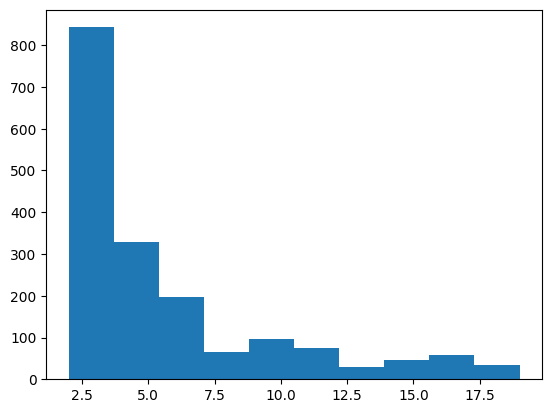

In [105]:
plt.hist(df_item_revs[(df_item_revs.id_usuario<20) & (df_item_revs.id_usuario>1) ].id_usuario)

In [106]:
df_revs_item_year = df_revs_clean.groupby(['item_id', 'year']).count()['id_usuario'].sort_values(ascending=False).reset_index()

In [108]:
# df_revs_clean.drop('posted', axis=1)

In [109]:
df_revs.funny = df_revs.funny.apply(limpiar_funny)
df_revs.helpful = df_revs.helpful.apply(limpiar_helpful)
df_revs.posted = df_revs.posted.apply(limpiar_posted)
df_revs.recommend = df_revs.recommend.map({True: 1, False: 0})

In [111]:
df_revs['year_posted'] = df_revs.posted.dt.year

In [113]:
df_revs_filtrada = df_revs[['item_id', 'year_posted', 'recommend', 'review_sent']]
df_revs_filtrada.to_csv('df_revs_filtrada.csv')
df_revs_filtrada.query("year_posted == 2016").groupby(['item_id', 'year_posted']).sum(['reviews_sent', 'recommend']).sort_values(by='recommend', ascending=False).head(3)

,,recommend,review_sent
item_id,year_posted,,
730,2016,649,1033
440,2016,252,439
4000,2016,150,244


# 2 Endpoints

#### 2.1 PlayTimeGenre(genero)

Debe devolver año con mas horas jugadas para dicho género.

In [148]:
# Vinculamos el archivo de generos exploded con las estadísticas de juego de cada usuario a través del campo id_game y el item_id
# Levantamos el archivo ya generado
genero_estadisticas = pd.read_csv('datasets/generos_estadisticas.csv')

# Creamos el ìndice compuesto y tomamos solo el valor de playtime_forever
genero_estadisticas = genero_estadisticas.set_index(['genres_x', 'release_year'])[['playtime_forever']]

# Elegimos un género de prueba
genero = 'Strategy'

# Filtramos el dataset por género, ordenamos de manera descendente, elegimos el primer elemento
anio_maximo = genero_estadisticas.query(f"genres_x == '{genero}'").sort_values(by='playtime_forever', ascending=False)
anio = pd.DataFrame(anio_maximo).reset_index().release_year.values[0]

print(anio)

2013


#### 2.2 UserForGenre(genero)

Debe devolver el usuario que acumula más horas jugadas para el género dado y una lista de la acumulación de horas jugadas por año.

In [161]:
# Levantamos un dataset ya generado en el que se encuentran los usuarios vinculados a los géneros de los juegos
# y con el valor playtime_forever ya acumulado como suma, de manera descendente
usuario_genero = pd.read_csv('datasets/usuario_genero.csv').reset_index()

# Elegimos un gènero
genero = 'Strategy'

# En base a ese género filtramos y encontramos el primer usuario
usuario = usuario_genero.query(f'genres == "{genero}"').head(1).user_id.values[0]

# Levantamos un dataset que tiene las estadísticas de usuarios vinculadas con el año de lanzamiento del juego
usuarios_genero_horas = pd.read_csv('datasets/merged_2.csv')

# Consultamos según el usuario que obtuvimos y el género
query = usuarios_genero_horas.query(f"user_id =='{usuario}' and genres == '{genero}'")

# Achatamos el dataset y su índice
query = query.reset_index()

# A través de esta lista de comprensión generamos el arreglo de diccionarios con el año y la cantidad de horas: Playtime_forever / 60
salida = [{f'Año {row[3]}': str(round(row[4]/60))} for i, row in enumerate(query.values)]

print(usuario, salida)

shinomegami [{'Año 2003': '8848'}, {'Año 2013': '2323'}, {'Año 2014': '1982'}, {'Año 2012': '1308'}, {'Año 2009': '1229'}, {'Año 2007': '1144'}, {'Año 2010': '847'}, {'Año 1993': '367'}, {'Año 1995': '341'}, {'Año 2002': '41'}, {'Año 2015': '38'}, {'Año 2011': '30'}]


#### 2.3 UserRecommend( año : int ):

Devuelve el top 3 de juegos MÁS recomendados por usuarios para el año dado. (reviews.recommend = True y comentarios positivos/neutrales)

In [164]:
# Usamos una matriz ya filtrada que tiene los valores del item, el año, la recomendación y el valor del sentimiento
df_revs_filtrada = pd.read_csv('datasets/df_revs_filtrada.csv')

# Elegimos un año como ejemplo
anio = 2012

# Filtramos según el año en cuestion y elegimos según la cantidad de recomendaciones que viene relacionada
# con el sentimiento de las reseñas
top3 = df_revs_filtrada.query(f"year_posted == {anio}").groupby(['item_id', 'year_posted']).sum(['reviews_sent', 'recommend']).sort_values(by='recommend', ascending=False).head(3)
top3.reset_index(inplace=True)

# Generamos un arreglo de diccionarios con el puesto y el id del juego
salida = [{f'Puesto {i+1}': str(row[0])} for i, row in enumerate(top3.values)]

print(salida)

[{'Puesto 1': '440'}, {'Puesto 2': '105600'}, {'Puesto 3': '4000'}]


#### 2.4  UsersWorstDeveloper (año) 

Devuelve el top 3 de desarrolladoras con juegos MENOS recomendados por usuarios para el año dado. (reviews.recommend = False y comentarios negativos)

In [168]:
# Levantamos los datos desde un dataset que tiene ya vinculados los desarrolladores, el año de la reseña,
# la suma de recomendaciones y el análisis de sentimiento
dev_rec = pd.read_csv('datasets/developer_year_rec.csv')

# Elegimos un año
anio = 2010

# Filtramos según ese año
query = dev_rec.query(f"year_posted == {anio}").head(3)

# Creamos un arreglo de diccionarios con el fin de mostrar la informaciòn
salida = [{f'Puesto {i+1}': str(row[0])} for i, row in enumerate(query.values)]

print(salida)

[{'Puesto 1': 'Playbrains'}, {'Puesto 2': 'DICE'}, {'Puesto 3': 'Gas Powered Games'}]


#### 2.5 sentiment_analysis( developer )

Según la empresa desarrolladora, se devuelve un diccionario con el nombre de la desarrolladora como llave y una lista con la cantidad total de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento como valor.

In [172]:
# Generamos un frame que contiene el anàlisis de sentimiento por cada reseña por cada juego po desarrolladora
df = pd.merge(df_revs[['item_id','review_sent']], df_games[['id_game','developer']], left_on='item_id', right_on='id_game').drop(['item_id','id_game'], axis=1).sort_values(by='developer')
df.dropna(inplace=True)

# Elegimos una desarrolladora al azar
desarrollador = 'Valve'

# Consultamos por esa empresa y contamos los valores por cada tipo de sentiment, 0, negativa, 1, neutral
# 2, positivas
negativas = df.query(f"developer == '{desarrollador}' and review_sent == 0").count().review_sent
neutrales = df.query(f"developer == '{desarrollador}'  and review_sent == 1").count().review_sent
positivas = df.query(f"developer == '{desarrollador}'  and review_sent == 2").count().review_sent

# Generamos el diccionario correspondiente
{'Negativas': negativas, 'Neutrales': neutrales, 'Positivas': positivas}

{'Negativas': 1134, 'Neutrales': 2387, 'Positivas': 6176}